In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf
color = sns.color_palette()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
data_dir = Path('/content/drive/My Drive/mask')

In [ ]:
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'validation'

In [ ]:
# Get the path to the with mask and non mask sub-directories
with_mask_dir = train_dir / 'with_mask'
non_mask_dir = train_dir / 'non_mask'


# Get the list of all the images
with_mask = with_mask_dir.glob('*.png')
non_mask = non_mask_dir.glob('*.png')
 

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the non mask cases. The label for these cases will be 0
for img in non_mask:
  train_data.append((img,0))

# Go through all the with mask cases. The label for these cases will be 1
for img in with_mask:
  train_data.append((img, 1))
 

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/My Drive/mask/train/non_mask/95...,0
1,/content/drive/My Drive/mask/train/non_mask/79...,0
2,/content/drive/My Drive/mask/train/non_mask/40...,0
3,/content/drive/My Drive/mask/train/non_mask/13...,0
4,/content/drive/My Drive/mask/train/with_mask/1...,1


0    1476
1    1291
Name: label, dtype: int64


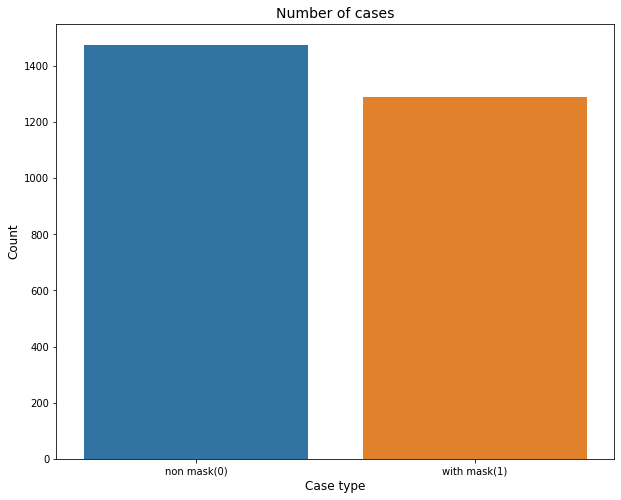

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['non mask(0)','with mask(1)'])
plt.show()

In [ ]:
train_data.shape

(2767, 2)

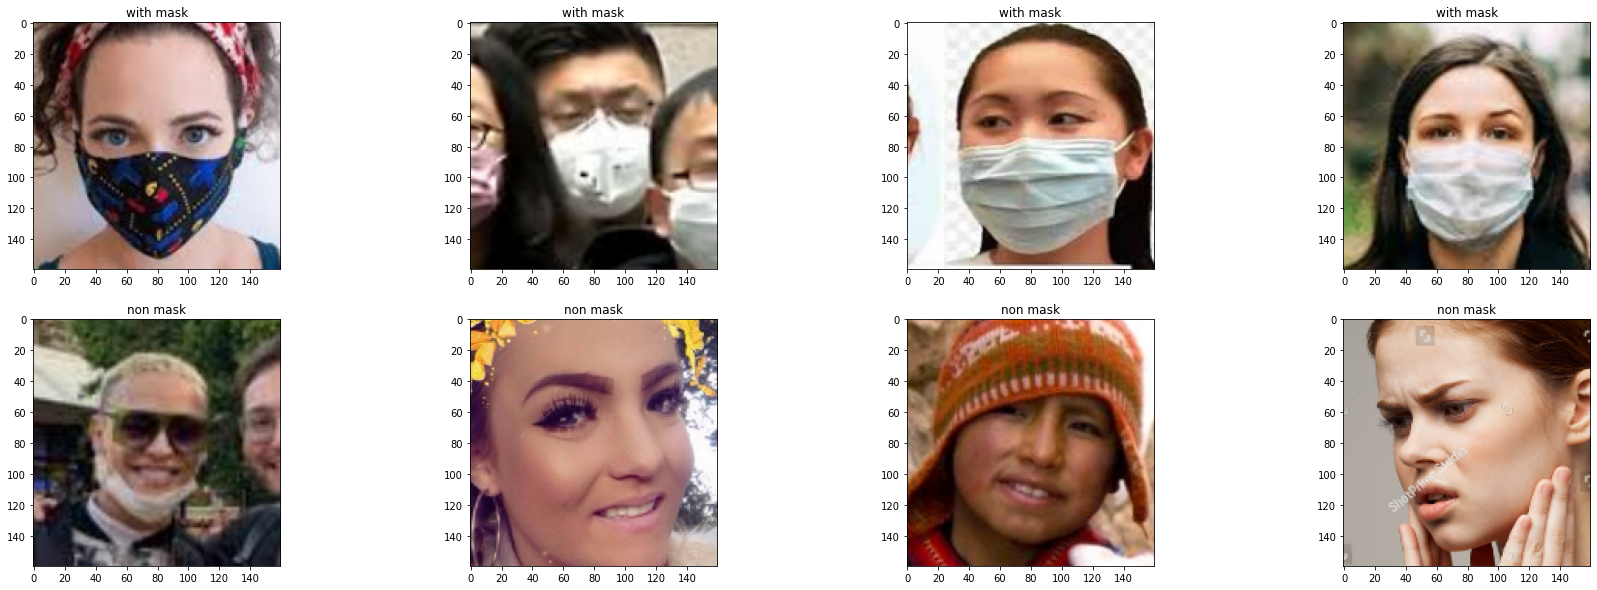

In [ ]:
# Get few samples for both the classes
with_mask_samples = (train_data[train_data['label']==1]['image'].iloc[:4]).tolist()
non_mask_samples = (train_data[train_data['label']==0]['image'].iloc[:4]).tolist()

# Concat the data in a single list and del the above two list
samples = with_mask_samples + non_mask_samples
del with_mask_samples, non_mask_samples

# Plot the data 
f, ax = plt.subplots(2,4, figsize=(30,10))
for i in range(8):
  img = imread(samples[i])
  ax[i//4, i%4].imshow(img)
  if i<4:
    ax[i//4, i%4].set_title("with mask")
  else:
    ax[i//4, i%4].set_title("non mask")
    
    ax[i//4, i%4].axis('on')
    ax[i//4, i%4].set_aspect('equal')
plt.show()

In [ ]:
non_mask_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

In [ ]:
non_mask_samples

[PosixPath('/content/drive/My Drive/mask/train/non_mask/959.png'),
 PosixPath('/content/drive/My Drive/mask/train/non_mask/792.png'),
 PosixPath('/content/drive/My Drive/mask/train/non_mask/402.png'),
 PosixPath('/content/drive/My Drive/mask/train/non_mask/1351.png'),
 PosixPath('/content/drive/My Drive/mask/train/non_mask/34.png')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


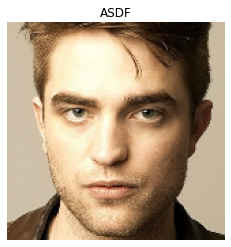

In [ ]:
import matplotlib.pyplot as plt
import PIL
for num, x in enumerate(non_mask_samples):
    img = PIL.Image.open(x)
    plt.subplot()
    plt.title("ASDF")
    plt.axis('off')
    plt.imshow(img)

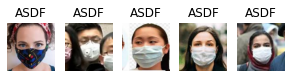

In [ ]:
with_mask_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
import matplotlib.pyplot as plt
import PIL
for num, x in enumerate(with_mask_samples):
    img = PIL.Image.open(x)
    plt.subplot(2,6,num+1)
    plt.title("ASDF")
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# Get the path to the sub-directories
with_mask_dir = val_dir / 'with_mask'
non_mask_dir = val_dir / 'non_mask'


#Get the list of all the images
with_mask = with_mask_dir.glob('*.png')
non_mask = non_mask_dir.glob('*.png')



# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

for img in non_mask:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (160,160))
  if img.shape[2] ==1:
     img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(0, num_classes=2)
  valid_data.append(img)
  valid_labels.append(label)
                  
     
for img in with_mask:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (160,160))
  if img.shape[2] ==1:
    img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(1, num_classes=2)
  valid_data.append(img)
  valid_labels.append(label)


    
# # Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (1543, 160, 160, 3)
Total number of labels: (1543, 2)


In [ ]:
# Get the path to the sub-directories
with_mask_dir = train_dir / 'with_mask'
non_mask_dir = train_dir / 'non_mask'


#Get the list of all the images
with_mask = with_mask_dir.glob('*.png')
non_mask = non_mask_dir.glob('*.png')



# List that are going to contain validation images data and the corresponding labels
train_data = []
train_labels = []

for img in non_mask:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (160,160))
  if img.shape[2] ==1:
     img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(0, num_classes=2)
  train_data.append(img)
  train_labels.append(label)
                  
     
for img in with_mask:
  img = cv2.imread(str(img))
  img = cv2.resize(img, (160,160))
  if img.shape[2] ==1:
    img = np.dstack([img, img, img])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype(np.float32)/255.
  label = to_categorical(1, num_classes=2)
  train_data.append(img)
  train_labels.append(label)


    
# # Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print("Total number of train examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of train examples:  (2767, 160, 160, 3)
Total number of labels: (2767, 2)


In [ ]:
def build_model():
    input_img = Input(shape=(160,160,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 160, 160, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 160, 160, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 160, 160, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 80, 80, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 80, 80, 128)       8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 80, 80, 128)       17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 40, 40, 128)       0   

In [ ]:
opt = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [ ]:
#batch_size = 5
#nb_epochs = 5

# Get a train data generator
#train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
#nb_train_steps = train_data.shape[0]//batch_size

#print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

In [ ]:
# # Fit the model
#history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              #validation_data=(valid_data, valid_labels))
                               

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:

#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

batch_stats = CollectBatchStats()

In [ ]:


reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
aug_num = 10 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 0.8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = aug_num / 100, # Randomly zoom image 
        width_shift_range= aug_num / 100,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= aug_num / 100,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=0.05,  # randomly flip images horizontally
        vertical_flip=True)  # randomly flip images vertically
        
datagen.fit(train_data)
batch_size = 128
epochs =  30
# Fit the Model
history = model.fit_generator(datagen.flow(train_data, train_labels, batch_size = batch_size), epochs = epochs, 
                              validation_data = (valid_data, valid_labels), verbose=2, 
                              steps_per_epoch=train_data.shape[0] // batch_size,
                              callbacks=[reduce_lr])

Epoch 1/30
 - 21s - loss: 0.2484 - accuracy: 0.9098 - val_loss: 0.8596 - val_accuracy: 0.4893
Epoch 2/30
 - 20s - loss: 0.2012 - accuracy: 0.9231 - val_loss: 0.5932 - val_accuracy: 0.6773
Epoch 3/30
 - 19s - loss: 0.1755 - accuracy: 0.9447 - val_loss: 0.6286 - val_accuracy: 0.6235
Epoch 4/30
 - 19s - loss: 0.1616 - accuracy: 0.9462 - val_loss: 0.6936 - val_accuracy: 0.5159
Epoch 5/30
 - 19s - loss: 0.1367 - accuracy: 0.9545 - val_loss: 1.5683 - val_accuracy: 0.5107
Epoch 6/30
 - 19s - loss: 0.1404 - accuracy: 0.9530 - val_loss: 0.9033 - val_accuracy: 0.3461
Epoch 7/30
 - 19s - loss: 0.1376 - accuracy: 0.9524 - val_loss: 1.4065 - val_accuracy: 0.5049
Epoch 8/30
 - 18s - loss: 0.1147 - accuracy: 0.9598 - val_loss: 0.8342 - val_accuracy: 0.3947
Epoch 9/30
 - 19s - loss: 0.1139 - accuracy: 0.9621 - val_loss: 2.5726 - val_accuracy: 0.5107
Epoch 10/30
 - 19s - loss: 0.1189 - accuracy: 0.9609 - val_loss: 3.2304 - val_accuracy: 0.5107
Epoch 11/30
 - 18s - loss: 0.1047 - accuracy: 0.9660 - val_

In [ ]:
train_labels = np.array([i[1] for i in train_labels])

In [ ]:
LE = LabelEncoder()
train_labels = LE.fit_transform(train_labels)
# One-hot Encoding
train_labels = np_utils.to_categorical(train_labels, 2)

In [ ]:
train_label

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
model.save('face_mask.h5')